In [1]:
import pandas as pd

df_btc = pd.read_csv("../data/quotes_BTC.csv")
df_btc["timestamp"] = df_btc["timestamp"].apply(lambda x: x[:10])
print(df_btc["timestamp"])
df_btc = df_btc.astype({"timestamp": "datetime64[s]"}).set_index("timestamp")
df_btc.head()

0     2024-08-21
1     2024-08-22
2     2024-08-23
3     2024-08-24
4     2024-08-25
         ...    
95    2024-11-24
96    2024-11-25
97    2024-11-26
98    2024-11-27
99    2024-11-28
Name: timestamp, Length: 100, dtype: object


,Unnamed: 0,percent_change_1h,percent_change_24h,percent_change_7d,percent_change_30d,price,volume_24h,market_cap,total_supply,circulating_supply
timestamp,,,,,,,,,,
2024-08-21,0,-0.259023,3.119146,3.822595,-9.291341,61220.255035,3.230223e+10,1.208683e+12,19743196,19743196
2024-08-22,1,-0.366595,-1.457215,4.719244,-8.518946,60328.144488,2.804668e+10,1.191099e+12,19743678,19743678
2024-08-23,2,-0.392219,6.412008,9.026376,-1.725949,64196.389701,4.164920e+10,1.267505e+12,19744178,19744178
2024-08-24,3,0.416369,-0.385213,7.679103,-2.732526,63949.097035,2.225770e+10,1.262655e+12,19744696,19744696
2024-08-25,4,0.251679,1.101118,8.943554,-4.825128,64653.252252,1.750459e+10,1.276586e+12,19745112,19745112


In [ ]:
import numpy as np

series = df_btc['price']
min = np.min(series)
max = np.max(series)
series -= min
series /= max
split_time = int(len(series) * 0.8)

time_train = df_btc.index[:split_time]
x_train = series[:split_time]
time_valid = df_btc.index[split_time:]
x_valid = series[split_time:]

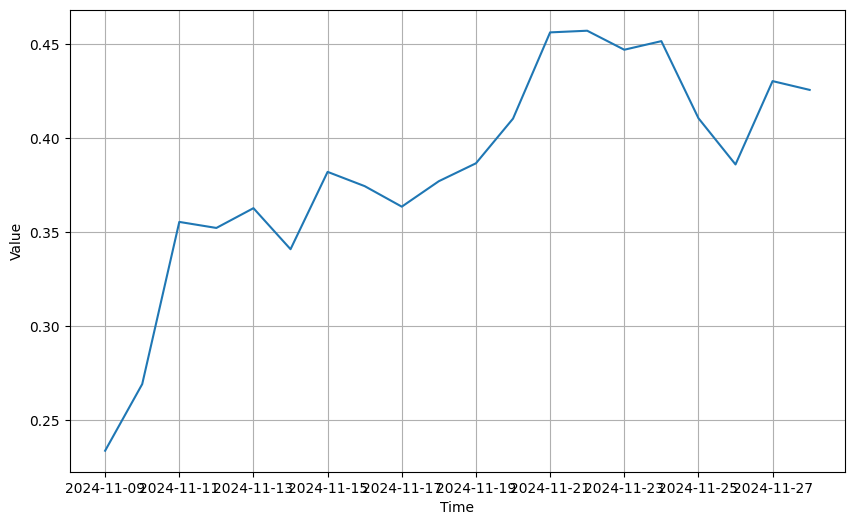

In [3]:
import matplotlib.pyplot as plt

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)

In [4]:
import tensorflow as tf

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

window_size = 5
batch_size = 10
shuffle_buffer_size = 100
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

for features, labels in dataset:
    print("Features:", features.numpy())
    print("Labels:", labels.numpy())

Features: [[[0.16619033]
  [0.19178233]
  [0.19074429]
  [0.16888305]
  [0.16024285]]

 [[0.        ]
  [0.00187367]
  [0.01130971]
  [0.03518222]
  [0.04020459]]

 [[0.09686935]
  [0.10170315]
  [0.09767462]
  [0.10943523]
  [0.09633851]]

 [[0.07236839]
  [0.07270873]
  [0.08541204]
  [0.08441313]
  [0.09168585]]

 [[0.14829027]
  [0.14842003]
  [0.15533768]
  [0.14082745]
  [0.14149677]]

 [[0.03518222]
  [0.04020459]
  [0.03885935]
  [0.04557064]
  [0.06955709]]

 [[0.04020459]
  [0.03885935]
  [0.04557064]
  [0.06955709]
  [0.06482847]]

 [[0.10943523]
  [0.09633851]
  [0.11510719]
  [0.12382236]
  [0.12177458]]

 [[0.12575961]
  [0.1354815 ]
  [0.14711303]
  [0.16619033]
  [0.19178233]]

 [[0.15253969]
  [0.14392323]
  [0.16095827]
  [0.22272793]
  [0.22441012]]]
Labels: [[0.15814925]
 [0.03885935]
 [0.11510719]
 [0.08980603]
 [0.13085264]
 [0.06482847]
 [0.05385919]
 [0.12106865]
 [0.19074429]
 [0.23077512]]
Features: [[[0.08938303]
  [0.09796452]
  [0.09139421]
  [0.12706269]
 

2024-12-19 19:11:48.534761: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [8]:
# Tune hyperparameters

import tensorflow as tf
from kerastuner.tuners import RandomSearch

def build_model(hp):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.LSTM(hp.Int('units', min_value=20, max_value=40, step=5), activation="relu", input_shape=(window_size, 1)))
  model.add(tf.keras.layers.Dense(1))

  model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[0.01, 0.001])))
  return model

tuner = RandomSearch(build_model, objective='loss', max_trials=50, executions_per_trial=3, directory='models', project_name='btc')

tuner.search_space_summary()

tuner.search(dataset, epochs=100, verbose=0)

tuner.results_summary()

/var/folders/pw/6x12jmwn6dx_wqvppt7_zpxw0000gn/T/ipykernel_47022/3924333299.py:4: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch
/Users/rlieu/machine-learning/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 20, 'max_value': 40, 'step': 5, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001], 'ordered': True}


/Users/rlieu/machine-learning/.venv/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
2024-12-19 19:14:29.456201: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-19 19:14:31.847670: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-19 19:14:37.458838: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-19 19:14:47.861671: I tensorflow/core/framework/local_rendezvous.cc

Results summary
Results in models/btc
Showing 10 best trials
Objective(name="loss", direction="min")

Trial 01 summary
Hyperparameters:
units: 40
learning_rate: 0.01
Score: 0.00022652499319519848

Trial 07 summary
Hyperparameters:
units: 25
learning_rate: 0.01
Score: 0.00022926821354000518

Trial 05 summary
Hyperparameters:
units: 30
learning_rate: 0.01
Score: 0.00023073299962561578

Trial 04 summary
Hyperparameters:
units: 35
learning_rate: 0.01
Score: 0.00023591850185766816

Trial 09 summary
Hyperparameters:
units: 20
learning_rate: 0.01
Score: 0.00024002225351675102

Trial 02 summary
Hyperparameters:
units: 20
learning_rate: 0.001
Score: 0.00044141522569892305

Trial 03 summary
Hyperparameters:
units: 35
learning_rate: 0.001
Score: 0.00045516326402624446

Trial 00 summary
Hyperparameters:
units: 30
learning_rate: 0.001
Score: 0.00045781593265322346

Trial 08 summary
Hyperparameters:
units: 40
learning_rate: 0.001
Score: 0.0004603199486155063

Trial 06 summary
Hyperparameters:
units:

In [ ]:
# Build model

import tensorflow as tf

optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)

model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(35,  activation="relu", input_shape=(window_size, 1)),  # LSTM layer
    tf.keras.layers.Dense(1)  # Output layer
])

model.compile(
    optimizer=optimizer,
    loss='mse',
    metrics=['mae']
)

# Train model
history = model.fit(dataset, epochs=100)

Epoch 1/100


/Users/rlieu/machine-learning/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0092 - mae: 0.0831
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0048 - mae: 0.0537
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0024 - mae: 0.0389
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0018 - mae: 0.0357
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0016 - mae: 0.0324
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0016 - mae: 0.0337
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0014 - mae: 0.0298
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0017 - mae: 0.0322
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0013 - mae: 0.0283
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0011 - mae: 0.0257    
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0011 - mae: 0.0271
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step - loss: 9.7115e-04 - mae: 0.0243


2024-12-19 19:11:49.047882: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/rlieu/machine-learning/.venv/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
2024-12-19 19:11:49.092092: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-19 19:11:49.163603: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Epoch 13/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0011 - mae: 0.0267
Epoch 14/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step - loss: 8.5595e-04 - mae: 0.0223
Epoch 15/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step - loss: 0.0010 - mae: 0.0243
Epoch 16/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step - loss: 7.1253e-04 - mae: 0.0192
Epoch 17/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step - loss: 6.1401e-04 - mae: 0.0185
Epoch 18/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step - loss: 5.5067e-04 - mae: 0.0176
Epoch 19/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.6044e-04 - mae: 0.0213 
Epoch 20/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.5944e-04 - mae: 0.0184
Epoch 21/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.2477e-04 - mae: 0.0195
Epoch 22/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.9598e-04 - mae: 0.0186
Epoch 23/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.7775e-04 - mae: 0.0188
Epoch 24/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.4119e-04 - mae: 0.0203
E

2024-12-19 19:11:49.296670: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.3351e-04 - mae: 0.0162
Epoch 29/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.2991e-04 - mae: 0.0204
Epoch 30/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.2820e-04 - mae: 0.0184
Epoch 31/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step - loss: 5.4452e-04 - mae: 0.0185
Epoch 32/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step - loss: 5.6387e-04 - mae: 0.0183
Epoch 33/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step - loss: 5.8535e-04 - mae: 0.0194
Epoch 34/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step - loss: 4.9391e-04 - mae: 0.0177
Epoch 35/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step - loss: 5.6061e-04 - mae: 0.0190
Epoch 36/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.5949e-04 - mae: 0.0192
Epoch 37/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step - loss: 6.2283e-04 - mae: 0.0200
Epoch 38/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step - loss: 5.4323e-04 - mae: 0.0189
Epoch 39/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - loss: 3.8003e-04 - mae: 0.0151
E

2024-12-19 19:11:49.555758: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.4230e-04 - mae: 0.0186
Epoch 45/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.5439e-04 - mae: 0.0189
Epoch 46/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step - loss: 6.0081e-04 - mae: 0.0189
Epoch 47/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step - loss: 5.1000e-04 - mae: 0.0186
Epoch 48/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step - loss: 5.4530e-04 - mae: 0.0192
Epoch 49/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step - loss: 4.8372e-04 - mae: 0.0176
Epoch 50/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step - loss: 4.5505e-04 - mae: 0.0167
Epoch 51/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.8786e-04 - mae: 0.0179
Epoch 52/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step - loss: 5.4708e-04 - mae: 0.0184
Epoch 53/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step - loss: 4.9487e-04 - mae: 0.0186
Epoch 54/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step - loss: 4.9961e-04 - mae: 0.0182
Epoch 55/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step - loss: 5.0387e-04 - mae: 0.0180

2024-12-19 19:11:50.065091: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.2690e-04 - mae: 0.0172
Epoch 77/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step - loss: 5.1818e-04 - mae: 0.0185
Epoch 78/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.5527e-04 - mae: 0.0181
Epoch 79/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.1935e-04 - mae: 0.0166
Epoch 80/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step - loss: 4.3832e-04 - mae: 0.0175
Epoch 81/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.7030e-04 - mae: 0.0171
Epoch 82/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step - loss: 4.4774e-04 - mae: 0.0171
Epoch 83/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step - loss: 4.3332e-04 - mae: 0.0167
Epoch 84/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step - loss: 4.3950e-04 - mae: 0.0171
Epoch 85/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step - loss: 4.1652e-04 - mae: 0.0166
Epoch 86/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step - loss: 4.7477e-04 - mae: 0.0176
Epoch 87/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - loss: 4.4869e-04 - mae: 0.0162
E

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


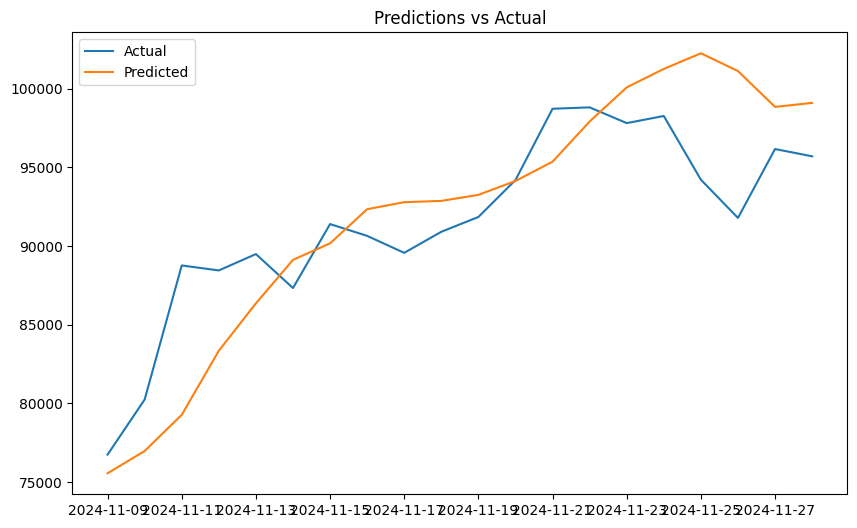

In [ ]:
# Evaluate results

import tensorflow as tf

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

forecast = model_forecast(model, series[split_time - window_size:-1], window_size)[:,0]


plt.figure(figsize=(10, 6))

scaled_xvalid=x_valid*max
scaled_xvalid=scaled_xvalid+min
scaled_forecast=forecast*max
scaled_forecast=scaled_forecast+min

plt.plot(time_valid, scaled_xvalid, label="Actual")
plt.plot(time_valid, scaled_forecast, label="Predicted")
plt.legend()
plt.title("Predictions vs Actual")
plt.show()